# End to End Time series Analysis

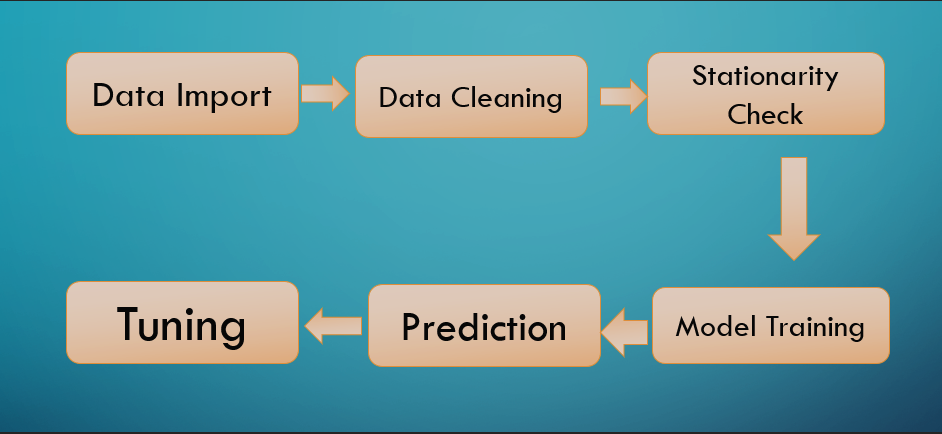

# importing libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import acf,pacf



#Lets pull data from kaggle

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir dataset
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data
!unzip climate-change-earth-surface-temperature-data.zip -d dataset

Saving kaggle.json to kaggle.json
 96% 81.0M/84.7M [00:01<00:00, 81.1MB/s]
100% 84.7M/84.7M [00:01<00:00, 79.9MB/s]
Archive:  climate-change-earth-surface-temperature-data.zip
  inflating: dataset/GlobalLandTemperaturesByCity.csv  
  inflating: dataset/GlobalLandTemperaturesByCountry.csv  
  inflating: dataset/GlobalLandTemperaturesByMajorCity.csv  
  inflating: dataset/GlobalLandTemperaturesByState.csv  
  inflating: dataset/GlobalTemperatures.csv  


In [3]:
TempData = pd.read_csv('/content/dataset/GlobalLandTemperaturesByCity.csv')
TempData.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
#Data Cleaning
TempData = TempData.dropna()
df_Denamrk = TempData[TempData.Country == "Denmark"]

df_Denamrk.index = pd.to_datetime(df_Denamrk.dt)
  
df_Denamrk = df_Denamrk.drop(['dt','AverageTemperatureUncertainty'], axis=1)
df_Denamrk.describe()


,AverageTemperature
count,12664.000000
mean,7.802640
std,6.648288
min,-7.816000
25%,2.084000
50%,7.200000
75%,14.190500
max,21.437000


In [5]:
ts = df_Denamrk['AverageTemperature']
ts

dt
1743-11-01     6.068
1744-04-01     5.788
1744-05-01    10.644
1744-06-01    14.051
1744-07-01    16.082
               ...  
2013-04-01     6.026
2013-05-01    12.774
2013-06-01    15.685
2013-07-01    18.735
2013-08-01    18.067
Name: AverageTemperature, Length: 12664, dtype: float64

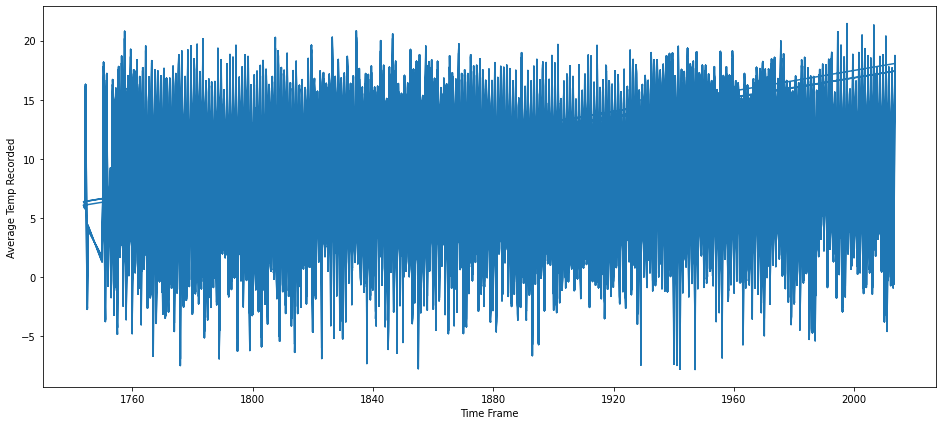

In [6]:
#Data Exploration
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel('Average Temp Recorded')
ax1.plot(ts)


In [9]:
# Perform Augmented Dickey-Fuller test:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(ts, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.764430391800643
p-value: 2.374697045635644e-27
Critial Values:
   1%, -3.430868192869495
Critial Values:
   5%, -2.86176901566292
Critial Values:
   10%, -2.566891900059256


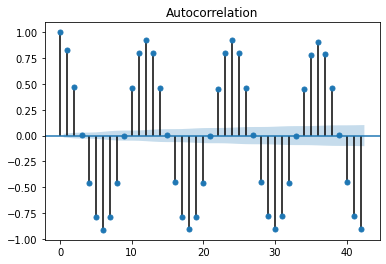

In [24]:
acftest = plot_acf(ts)

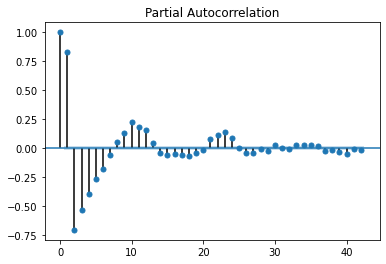

In [25]:
pacftest = plot_pacf(ts)

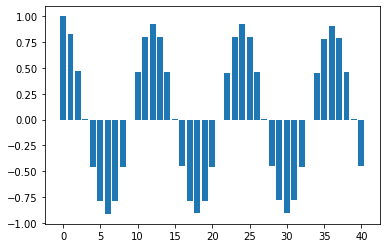

In [32]:
acfcheck = acf(ts)
acfdf = pd.DataFrame(data = acfcheck)
plt.bar(acfdf.index,acfdf[0])
plt.show()

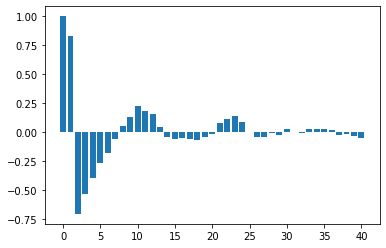

In [33]:
pacfcheck = pacf(ts)
pacfdf = pd.DataFrame(data = pacfcheck)
plt.bar(pacfdf.index,pacfdf[0])
plt.show()

In [34]:
#First model
newmodel = ARMA(ts,order=(1,1))
results = newmodel.fit()

predictions = results.predict('01/01/1990', '01/01/1991')

In [35]:
actuals = df_Denamrk['01/01/1990': '01/01/1991']['AverageTemperature'][0:13]

In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actuals[0:13], predictions)
print('MAE: %f' % mae)

MAE: 1.812791


In [37]:
import itertools
i = j = range(0, 4)
ij = itertools.product(i,j)
for parameters in ij:
    try:
        mod = ARMA(ts,order=parameters)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(parameters, results.aic))
    except:
        continue

ARMA(0, 0) - AIC:83922.21129983963
ARMA(0, 1) - AIC:72682.79463953726
ARMA(0, 3) - AIC:63785.445727051265
ARMA(1, 0) - AIC:69020.31146791195
ARMA(1, 1) - AIC:65268.10421609925
ARMA(1, 2) - AIC:63179.848013832176
ARMA(1, 3) - AIC:66639.60428407871
ARMA(2, 0) - AIC:60366.309092605945
ARMA(2, 2) - AIC:52219.29608248227
ARMA(2, 3) - AIC:50711.73170571691
ARMA(3, 0) - AIC:56175.945552185905
ARMA(3, 1) - AIC:53338.63499200792
ARMA(3, 2) - AIC:50395.14054797271
ARMA(3, 3) - AIC:50388.95755986136


In [38]:
predictions = results.predict('01/01/1990', '01/01/1991')

In [39]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actuals[0:13], predictions)
print('MAE: %f' % mae)

MAE: 1.494525
